In [1]:
import numpy as np
import random

file_path = "/kaggle/input/next-word-prediction/1661-0.txt"

with open(file_path, "r") as file:
    raw_text = file.readlines()


FileNotFoundError: [Errno 2] No such file or directory: '/kaggle/input/next-word-prediction/1661-0.txt'

In [53]:
merged_text = " ".join(raw_text)

# Optional: Strip extra spaces and normalize spacing
merged_text = merged_text.replace("\n", " ").replace("\r", " ").strip()
merged_text = " ".join(merged_text.split())  # Ensure single spacing

merged_text = merged_text[1171:]

In [54]:
import re
# sentences = merged_text 
sentences = re.split(r'(?<=[.!?])\s+', merged_text.strip())

In [55]:
sentences = sentences[:50]

print(len(sentences))

50


In [56]:
vocab = list(set(word for sentence in sentences for word in sentence.split()))
vocab.append("<UNK>")  # Thêm token đặc biệt
print(vocab)

['before', 'returning', 'servant', 'position.', 'top-hat', 'woman', 'process.', 'her', 'chest', 'doings:', 'hot', 'can’t', 'fail', 'official', 'sunk', 'fierce', 'chamber', 'this', 'might', 'effusive.', 'you', 'actions.', 'yourself', 'there?”', 'rooms', 'still,', 'have', 'finally', 'clear.', 'motives', 'adjusted', 'following', 'too', 'world', 'reasoning', 'such', 'deeply', 'twentieth', 'member', 'would', 'Watson.', 'getting', 'name.', 'good', 'each', 'figure', 'You', 'baffled', 'drawing', 'yours.”', 'placed', 'dreams', 'summons', 'desire', 'that', 'drug,', 'twice', 'out.”', 'times.”', 'there', 'caused', 'forefinger,', 'around', '“Indeed,', 'lived', 'tell', 'Bohemian', 'though', 'clumsy', 'home-centred', 'Obviously', 'armchair,', 'word', 'powers.', 'sex.', 'instance', 'his', 'time', 'me', 'eyes', 'extraordinary', 'you,”', 'blind.', 'successive', 'Holmes', 'himself', 'be', 'delicately', 'factor', 'against', 'so!', 'take', 'black', 'across', 'scored', 'passions,', 'often?”', 'signs', 'inte

In [57]:
from transformers import AutoTokenizer, AutoModel
import torch

# Load pre-trained BERT tokenizer and model
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")
model = AutoModel.from_pretrained("bert-base-uncased")
# model = model.to("cuda")  # Use GPU if available

In [58]:
embedded_sentences = [] 
embedded_words = [] 

for i, sentence in enumerate(sentences):
    
    # Tokenize the sentence into subwords
    encoded_input = tokenizer(sentence, return_tensors="pt", padding=True, truncation=True, max_length=32, return_offsets_mapping=True, is_split_into_words=False )
    input_ids = encoded_input['input_ids']  # Move inputs to GPU
    attention_mask = encoded_input['attention_mask']
    
    # Get embeddings from the model
    with torch.no_grad():
        outputs = model(input_ids, attention_mask=attention_mask)
    
    # Extract last hidden state (word embeddings)
    word_embeddings = outputs.last_hidden_state.squeeze(0)  # Shape: (sequence_length, hidden_size)

    embedded_sentences.append(word_embeddings)  

    if ( i % 100 == 0 ) : 
        print(i) 


0


In [59]:

for i, word in enumerate(vocab):
    
    # Tokenize the sentence into subwords
    encoded_input = tokenizer(word, return_tensors="pt", padding=True, truncation=True, max_length=32, return_offsets_mapping=True, is_split_into_words=False )
    input_ids = encoded_input['input_ids'] 
    attention_mask = encoded_input['attention_mask']
    
    # Get embeddings from the model
    with torch.no_grad():
        outputs = model(input_ids, attention_mask=attention_mask)
    
    # Extract last hidden state (word embeddings)
    word_embeddings = outputs.last_hidden_state.squeeze(0)  # Shape: (sequence_length, hidden_size)

    word_embeddings = torch.mean(word_embeddings[1:-1], dim=0)
    # word_embeddings = mean( word_embeddings[1:word_embeddings.size-1])
    embedded_words.append((word, np.array(word_embeddings.reshape(768, 1))))  

    if ( i % 100 == 0 ) : 
        print(i) 

0
100
200
300
400
500
600


In [60]:

# print(embedded_sentences[2]) 

In [61]:
# Tạo dữ liệu huấn luyện
def create_training_data(sentences):
    data = []
    
    for sentence in sentences:
        for end in range(5 , len(sentence)-1 ):
            input_seq = sentence[1:end]
            target_word = sentence[end]
            data.append((input_seq, target_word))
    return data


training_data =create_training_data(embedded_sentences)


In [62]:
import numpy as np

# Lưu từng cặp (input_seq, target_word) thành các tệp nhỏ
for i, (input_seq, target_word) in enumerate(training_data):
    np.savez_compressed(f"training_data_{i}.npz", input_seq=input_seq, target_word=target_word)


In [63]:
for i, (input_seq, target_word) in enumerate(training_data[:5]):
    print(f"Example {i + 1}:")
    print(f"Input sequence length: {len(input_seq)}")
    print(f"Input sequence shape: {[embedding.shape for embedding in input_seq]}")
    print(f"Target word shape: {target_word.shape}")
    print("=" * 50)

Example 1:
Input sequence length: 4
Input sequence shape: [torch.Size([768]), torch.Size([768]), torch.Size([768]), torch.Size([768])]
Target word shape: torch.Size([768])
Example 2:
Input sequence length: 5
Input sequence shape: [torch.Size([768]), torch.Size([768]), torch.Size([768]), torch.Size([768]), torch.Size([768])]
Target word shape: torch.Size([768])
Example 3:
Input sequence length: 6
Input sequence shape: [torch.Size([768]), torch.Size([768]), torch.Size([768]), torch.Size([768]), torch.Size([768]), torch.Size([768])]
Target word shape: torch.Size([768])
Example 4:
Input sequence length: 7
Input sequence shape: [torch.Size([768]), torch.Size([768]), torch.Size([768]), torch.Size([768]), torch.Size([768]), torch.Size([768]), torch.Size([768])]
Target word shape: torch.Size([768])
Example 5:
Input sequence length: 8
Input sequence shape: [torch.Size([768]), torch.Size([768]), torch.Size([768]), torch.Size([768]), torch.Size([768]), torch.Size([768]), torch.Size([768]), torch.

In [64]:
import numpy as np

# Chuyển đổi training_data sang NumPy arrays
training_data = [(np.array(input_seq.numpy()), np.array(target_word.numpy())) for input_seq, target_word in training_data]


In [65]:
training_data = [
    (
        np.array([x.reshape(768, 1) for x in input_seq]),  # Đảm bảo từng vector trong input_seq là (768, 1)
        np.array(target_word).reshape(768, 1)             # Đảm bảo target_word là (768, 1)
    )
    for input_seq, target_word in training_data
]

print(training_data[1][0][1].shape, training_data[1][1].shape)

(768, 1) (768, 1)


In [66]:
print(len(training_data))

870


In [67]:


def softmax(xs):
    return np.exp(xs) / np.sum(np.exp(xs), axis=0)
def calculate_mse(out, target_word):
    mse = np.mean((out - target_word) ** 2)
    return mse
    
# Định nghĩa lớp RNN
class RNN:
    def __init__(self, input_size, output_size, hidden_size=512):
        self.Whh = np.random.randn(hidden_size, hidden_size) / 1000
        self.Wxh = np.random.randn(hidden_size, input_size) / 1000
        self.Why = np.random.randn(output_size, hidden_size) / 1000
        self.bh = np.zeros((hidden_size, 1))
        self.by = np.zeros((output_size, 1))

    def forward(self, inputs):
        h = np.zeros((self.Whh.shape[0], 1))
        self.last_inputs = inputs
        self.last_hs = {0: h}
        for i, x in enumerate(inputs):
            h = np.tanh(self.Wxh @ x + self.Whh @ h + self.bh)
            # print(h.shape)
            self.last_hs[i + 1] = h
        y = self.Why @ h + self.by
    
        return y, h

    def backprop(self, d_y, learn_rate=2e-4):
        n = len(self.last_inputs)
        d_Why = d_y @ self.last_hs[n].T
        d_by = d_y
        d_Whh = np.zeros(self.Whh.shape)
        d_Wxh = np.zeros(self.Wxh.shape)
        d_bh = np.zeros(self.bh.shape)
        d_h = self.Why.T @ d_y
        for t in reversed(range(n)):
            temp = ((1 - self.last_hs[t + 1] ** 2) * d_h)
            d_bh += temp
            d_Whh += temp @ self.last_hs[t].T
            d_Wxh += temp @ self.last_inputs[t].T
            d_h = self.Whh @ temp
        for d in [d_Wxh, d_Whh, d_Why, d_bh, d_by]:
            d[:] = np.clip(d, -1, 1)
        self.Whh -= learn_rate * d_Whh
        self.Wxh -= learn_rate * d_Wxh
        self.Why -= learn_rate * d_Why
        self.bh -= learn_rate * d_bh
        self.by -= learn_rate * d_by

# Khởi tạo RNN
rnn = RNN(768, 768)

import matplotlib.pyplot as plt

loss_history = [] 

# Huấn luyện RNN
def train_rnn(data, epochs=5):
    global loss_history
    for epoch in range(epochs):
        loss = 0
        cnt = 1
        for input_words, target_word in data:
            out, _ = rnn.forward(input_words)
            # probs = softmax(out)
            loss += calculate_mse( target_word, out) 
            d_L_d_y = (2*out - 2*target_word) / 768 
            # d_L_d_y[target_idx] -= 1
            # print(out.shape) 
            rnn.backprop(d_L_d_y)
            if cnt % 100 == 0: 
                avg_loss = loss / cnt 
                print(f"Iteration {cnt}: Current Loss = {avg_loss:.4f}")
            cnt = cnt + 1 
        avg_loss = loss / len(data)
        loss_history.append(avg_loss)
        print(f"Epoch {epoch + 1}, Loss: {avg_loss.item():.4f}")


train_rnn(training_data)


Iteration 100: Current Loss = 0.2834
Iteration 200: Current Loss = 0.2798
Iteration 300: Current Loss = 0.2793
Iteration 400: Current Loss = 0.2784
Iteration 500: Current Loss = 0.2811
Iteration 600: Current Loss = 0.2790
Iteration 700: Current Loss = 0.2795
Iteration 800: Current Loss = 0.2798
Epoch 1, Loss: 0.2766
Iteration 100: Current Loss = 0.2834
Iteration 200: Current Loss = 0.2797
Iteration 300: Current Loss = 0.2792
Iteration 400: Current Loss = 0.2783
Iteration 500: Current Loss = 0.2811
Iteration 600: Current Loss = 0.2790
Iteration 700: Current Loss = 0.2794
Iteration 800: Current Loss = 0.2797
Epoch 2, Loss: 0.2765
Iteration 100: Current Loss = 0.2833
Iteration 200: Current Loss = 0.2796
Iteration 300: Current Loss = 0.2792
Iteration 400: Current Loss = 0.2782
Iteration 500: Current Loss = 0.2810
Iteration 600: Current Loss = 0.2789
Iteration 700: Current Loss = 0.2794
Iteration 800: Current Loss = 0.2797
Epoch 3, Loss: 0.2764
Iteration 100: Current Loss = 0.2832
Iteration

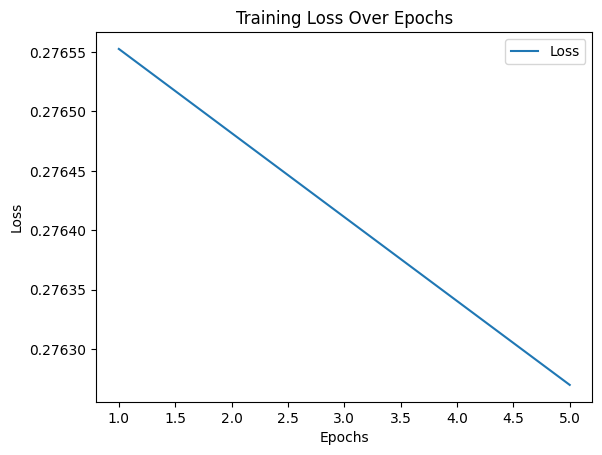

In [68]:
plt.plot(range(1, len(loss_history) + 1), loss_history, label="Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training Loss Over Epochs")
plt.legend()
plt.show()

In [104]:
def predict_next_words(input_words, top_k=2):
    # Chuyển đổi câu thành embedding
    encoded_input = tokenizer(input_words, return_tensors="pt", padding=True, truncation=True, max_length=32, return_offsets_mapping=True, is_split_into_words=False )
    input_ids = encoded_input['input_ids']
    attention_mask = encoded_input['attention_mask']

    # Tạo embedding từ mô hình
    with torch.no_grad():
        outputs = model(input_ids, attention_mask=attention_mask)
    word_embeddings = outputs.last_hidden_state.squeeze(0)  # Shape: (sequence_length, hidden_size)

    print(input_ids)
    word_embeddings = [np.array(word.reshape(768, 1)) for word in word_embeddings]

    # Truyền qua RNN
    out, _ = rnn.forward(word_embeddings)

    mse = [] 
    for (word, embedded_v) in embedded_words : 
        mse.append((word, calculate_mse(out, embedded_v)))

    # print(embedded_words[:5]) 
    
    mse_sorted = sorted(mse, key=lambda x: x[1]) 
    # print(mse_sorted[1][0])
    predictions = [row[0] for row in mse_sortedattention_mask[:top_k]]
    return predictions

In [ ]:
while True:
    user_input = input("Enter a sentence (or type 'exit' to quit): ")
    if user_input.lower() == 'exit':
        print("Exiting the program. Goodbye!")
        break
    input_words = user_input.lower()
    try:
        predicted_words = predict_next_words(input_words, top_k=2)
        print(f"Input: {' '.join(user_input)}")
        # print(predicted_words)
        print(f"Predicted next words: {', '.join(predicted_words)}")
    except KeyError as e:
        print(f"Error: {e}. Please ensure your input contains words from the vocabulary.")

Enter a sentence (or type 'exit' to quit):  i am going to 


tensor([[ 101, 1045, 2572, 2183, 2000,  102]])
Input: i   a m   g o i n g   t o  
Predicted next words: “Quite, “Seven!”
